# Environment

In [1]:
import gym
import numpy as np

import os

import matplotlib.pyplot as plt

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

In [2]:
name = "LunarLander-v2"
env = gym.make(name)
spec = gym.spec(name)

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}")

Action Space: Discrete(4)
Observation Space: Box(8,)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Helper functions

In [3]:
def evaluate(model, num_episodes=20, verbose=1):
    """
    Evaluate a RL agent
    :param model: the RL Agent
    :param num_episodes: number of episodes to evaluate it
    :return: Mean reward for the last num_episodes
    """
    all_episode_rewards = np.zeros((num_episodes))
    qvals = []

    env = gym.make(name)

    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        
        while not done:
            qval = model.dqn(np.array([obs]))[0]
            action = np.argmax(qval)
            qvals.append(np.max(qval))
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards[i] = sum(episode_rewards)

    env.close()

    mean_episode_reward = np.mean(all_episode_rewards)
    mean_q_value = np.mean(qvals)
    if verbose:
        print("Evaluation *** Mean reward:", mean_episode_reward, "Mean Q-value:", mean_q_value)

    return mean_episode_reward, mean_q_value

In [4]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

log_dir = f'logs/{name}/'
video_folder = log_dir + 'video'

def save_episode(model, comment):
    video_length = 3000
    env = DummyVecEnv([lambda: gym.make(name)])

    # Record the video
    env = VecVideoRecorder(env, video_folder,
                        record_video_trigger=lambda x: x == 0,
                        video_length=video_length,
                        name_prefix="DQL-{}-{}".format(name, comment))

    # Simulate game
    obs = env.reset()
    for _ in range(video_length + 1):
        action = np.argmax(model.dqn(np.array(obs))[0])
        obs, _, done, _ = env.step([action])

        if done:
            break

    env.close()

# Model

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D,
                                     Dense,
                                     Input,
                                     Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow import keras
import tensorflow as tf

2021-07-17 12:13:28.887913: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [6]:
def build_model(input_shape, output_shape):
    x = Input(shape=(input_shape))

    hidden = Dense(64, activation="relu")(x)
    hidden = Dense(32, activation="relu")(hidden)
    hidden = Dense(16, activation="relu")(hidden)

    y = Dense(output_shape, activation="linear")(hidden)

    model = Model(inputs=x, outputs=y)
    return model

optimizer = Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.mse

# Replay Memory

In [7]:
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size

    def push(self, *args):
        """ Save a transition """
        self.memory.append(Transition(*args))

    def sample(self):
        """ Get a random element from the memory buffer """
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)

# Deep Q-Learning Training Loop

In [8]:
class DeepQLearning :
    def __init__(self, env, capacity=1000000, batch_size=64, max_frames=3000, gamma=0.99, epsilon=1.0):
        """
        :param env: OpenAI RL environment to solve
        :param capacity: Replay Buffer memory size
        :param batch_size: Size of the H.E.R.
        :param max_frames: Max number of iteration in a single gameplay
        :param gamma: Decay factor
        :param epsilon: Exploration term
        """
        self.env = env
        self.dqn = build_model(env.observation_space.shape, env.action_space.n)
        self.dqn_target = build_model(env.observation_space.shape, env.action_space.n)
        self.dqn_target.set_weights(self.dqn.get_weights())
        self.memory = ReplayMemory(capacity, batch_size)
        self.max_frames = max_frames
        self.gamma = gamma
        self.epsilon = epsilon

    def _bellman_equation(self):
        """
        Update the Q-Learning table with discounted reward
        """
        # Sample batch
        transitions = self.memory.sample()
        state, action, next_state, reward, done = Transition(*zip(*transitions))

        # Q value = reward + discount factor * expected future reward
        future_q_values = self.dqn_target(np.stack(next_state))
        # future_q_values = self.dqn_target(np.stack(next_state))
        updated_q_values = reward + self.gamma * (tf.reduce_max(future_q_values, axis=1)) * (1 - np.array(done))
        
        # Mask all the action not taken
        masks = tf.one_hot(action, env.action_space.n)

        with tf.GradientTape() as tape:
            q_values = self.dqn(np.stack(state))
            # Select the predicted q-values of action taken
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)

            loss = loss_fn(updated_q_values, q_action)
            # loss = tf.reduce_mean(loss_fn(updated_q_values, q_action)) # ?
            
        # Backpropagation
        grads = tape.gradient(loss, self.dqn.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.dqn.trainable_variables))

    def _epsilon_decay(self, exploration_steps):
        """
        Decay the exploration factor in training.
        :param exploration_steps: Number of steps until stoping random exploration 
        :return: new exploration factor
        """
        epsilon_decay = (1 - 0.1) / exploration_steps
        return max(self.epsilon - epsilon_decay, 0.1)


    def predict(self, obs):
        """
        Q-Learning table lookup for decision making.
        :param obs: Current observation of the agent
        :return: Action the agent will make & the associated q-values.
        """
        if np.random.uniform(0, 1) < self.epsilon:
            # Select a random action at random occurrences
            return self.env.action_space.sample(), _
        # Select optimal action
        qvals = self.dqn(np.array([obs]))[0]
        return np.argmax(qvals), _

    def learn(self, episodes, exploration_steps, verbose=1):
        """ 
        Deep Q-Learning updating through game-playing
        """
        scores = []
        timesteps = 0

        for episode in range(episodes):
            self.dqn_target.set_weights(self.dqn.get_weights())
            # Reset variables for new game
            state = self.env.reset()
            done = False
            episode_reward = 0
            steps = 0

            while not done and steps <= 3000:
                # Predict new decision
                action, _ = self.predict(state)

                # Simulate decision
                next_state, reward, done, info = self.env.step(action)

                # Save step
                self.memory.push(state, action, next_state, reward, done)

                if self.memory.__len__() > 64:
                    # Decay exploration
                    self.epsilon = self._epsilon_decay(exploration_steps)
    
                    # Policy Gradient
                    self._bellman_equation()

                # Track the run
                state = next_state
                episode_reward += reward
                steps += 1

            scores.append(episode_reward)
            timesteps += steps

            if episode_reward > 195 and verbose:
                print('* Solved *')

            if not episode % 10 and verbose:
                print(f'Episode {episode} - Mean reward {np.mean(scores[-100:]):0.2f} - Episode reward {episode_reward:0.2f} - Epsilon {self.epsilon:0.2f}.')
            
            if (not episode % 50 or episode == episodes - 1) and verbose:
                self.dqn.save(log_dir + f"weigths/DQN_Episode-{episode}.h5")
                save_episode(self, episode)
        
        self.total_steps = timesteps

## Random Agent

In [9]:
# Create log dir
log_dir = f"logs/{name}/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make(name)
# Logs will be saved in log_dir/
env = Monitor(env, log_dir)
env.seed(0)

/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[0]

In [10]:
model = DeepQLearning(env)

evaluate(model)

save_episode(model, 'RandomAgent')

2021-07-17 12:13:30.179953: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-17 12:13:30.217173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-17 12:13:30.217891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2021-07-17 12:13:30.217937: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-17 12:13:30.222524: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-17 12:13:30.222685: I tensorflow/stream_executor/pl

Evaluation *** Mean reward: -546.8044720976152 Mean Q-value: 0.12757565


## Agent Training

In [11]:
episodes = 400
exploration_steps = 5e3

model.learn(episodes, exploration_steps)

Episode 0 - Mean reward -396.30 - Episode reward -396.30 - Epsilon 0.99.


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 10 - Mean reward -160.92 - Episode reward -87.86 - Epsilon 0.80.
Episode 20 - Mean reward -132.78 - Episode reward -102.67 - Epsilon 0.61.
Episode 30 - Mean reward -155.28 - Episode reward -283.82 - Epsilon 0.31.
Episode 40 - Mean reward -173.78 - Episode reward -220.03 - Epsilon 0.10.
Episode 50 - Mean reward -159.18 - Episode reward -76.44 - Epsilon 0.10.


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 60 - Mean reward -148.04 - Episode reward -51.90 - Epsilon 0.10.
Episode 70 - Mean reward -137.73 - Episode reward -80.40 - Epsilon 0.10.
Episode 80 - Mean reward -140.85 - Episode reward -128.68 - Epsilon 0.10.
Episode 90 - Mean reward -132.75 - Episode reward -19.89 - Epsilon 0.10.
Episode 100 - Mean reward -123.44 - Episode reward -47.68 - Epsilon 0.10.


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 110 - Mean reward -115.60 - Episode reward -113.68 - Epsilon 0.10.
* Solved *
* Solved *
Episode 120 - Mean reward -103.93 - Episode reward -51.89 - Epsilon 0.10.
* Solved *
* Solved *
Episode 130 - Mean reward -76.98 - Episode reward -13.62 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
Episode 140 - Mean reward -42.00 - Episode reward 56.75 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 150 - Mean reward -19.07 - Episode reward 257.97 - Epsilon 0.10.


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 160 - Mean reward 8.19 - Episode reward 202.03 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 170 - Mean reward 28.22 - Episode reward 256.66 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 180 - Mean reward 64.55 - Episode reward 197.34 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 190 - Mean reward 93.62 - Episode reward 168.75 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 200 - Mean reward 119.79 - Episode reward 42.25 - Epsilon 0.10.


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 210 - Mean reward 147.10 - Episode reward 302.99 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 220 - Mean reward 165.09 - Episode reward 308.69 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 230 - Mean reward 178.68 - Episode reward 229.78 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 240 - Mean reward 187.46 - Episode reward 153.90 - Epsilon 0.10.
* Solved *
Episode 250 - Mean reward 177.69 - Episode reward 221.05 - Epsilon 0.10.


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


* Solved *
* Solved *
* Solved *
Episode 260 - Mean reward 157.64 - Episode reward 312.11 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 270 - Mean reward 166.72 - Episode reward 256.21 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 280 - Mean reward 158.78 - Episode reward -92.95 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
Episode 290 - Mean reward 149.85 - Episode reward -138.50 - Epsilon 0.10.
* Solved *
Episode 300 - Mean reward 135.09 - Episode reward -36.84 - Epsilon 0.10.


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 310 - Mean reward 120.35 - Episode reward 199.29 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 320 - Mean reward 123.89 - Episode reward 267.45 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 330 - Mean reward 127.81 - Episode reward 235.74 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 340 - Mean reward 131.79 - Episode reward 255.83 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 350 - Mean reward 148.89 - Episode reward 257.34 - Epsilon 0.10.


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 360 - Mean reward 167.76 - Episode reward 220.74 - Epsilon 0.10.
* Solved *
* Solved *
Episode 370 - Mean reward 144.21 - Episode reward -208.95 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
Episode 380 - Mean reward 140.19 - Episode reward -3.59 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *
Episode 390 - Mean reward 144.64 - Episode reward 263.58 - Epsilon 0.10.
* Solved *
* Solved *
* Solved *
* Solved *
* Solved *


/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Evaluation

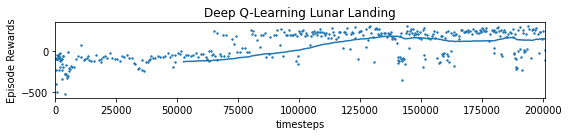

In [12]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], model.total_steps, results_plotter.X_TIMESTEPS, "Deep Q-Learning Lunar Landing")

(200879,)


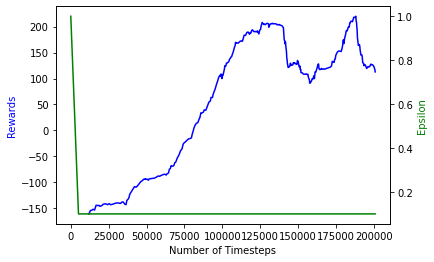

In [19]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y1 = ts2xy(load_results(log_folder), 'timesteps')
    y1 = moving_average(y1, window=50)
    # Truncate x
    x = x[len(x) - len(y1):]

    # Exploration epsilon values
    epsilon_decay = (1 - 0.1) / exploration_steps
    y2 = np.array([max(1 - epsilon_decay * time, 0.1) for time in range(model.total_steps)])#[x[x < total_steps]]
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'b-')
    ax2.plot(np.arange(model.total_steps), y2, 'g-')

    ax1.set_xlabel('Number of Timesteps')
    ax1.set_ylabel('Rewards', color='b')
    ax2.set_ylabel('Epsilon', color='g')

    plt.show()

plot_results(log_dir)

In [14]:
_ = evaluate(model)

save_episode(model, 'TrainedAgent')

/home/pf/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Evaluation *** Mean reward: 232.48679856918733 Mean Q-value: 80.27744
